¿Sería mejor diferenciar los vuelos para el modelo?
Si quieres un modelo que prediga precios reales → NO

No necesitas diferenciar:

- “1-stop via Hyderabad”
- “1-stop via Kolkata”

Porque:

- No afecta al precio
- No aporta información útil
- Añade ruido
- Aumenta la dimensionalidad
- Empeora el modelo

Las aerolíneas no fijan precios según la ciudad de escala.
Fijan precios según:

- número de escalas
- duración
- demanda
- antelación
- competencia
- franja horaria

1. ¿Por qué fijar una fecha artificial NO daña el proyecto?
Porque en el webscraping no existía la fecha real de consulta, y sin esa fecha:

no puedes calcular la anticipación

no puedes modelar la dinámica temporal

no puedes explicar por qué un vuelo vale 50€ hoy y 200€ mañana

el modelo no aprende nada útil

La anticipación es la variable más importante en pricing aéreo.
Sin ella, el modelo sería ciego.

Por eso fijar una fecha artificial es la única forma correcta de reconstruir esa variable.

2. ¿Es suficiente para un proyecto bueno?
- Sí, totalmente suficiente.
- Es una práctica habitual en proyectos reales.
- Es defendible técnicamente.
- Es coherente con el plan de negocio.

De hecho, en consultoría y data science se hace constantemente cuando:

- falta la fecha de scraping
- falta la fecha de compra
- falta la fecha de registro
- los datos vienen de APIs sin timestamp
- Lo importante no es la fecha exacta, sino la consistencia.

3. ¿Por qué el 11 de febrero es válido?

Porque:

- es una fecha fija

- es anterior a los vuelos del dataset

- permite calcular la anticipación

- no introduce sesgos

- no afecta a la comparación entre aerolíneas

- Si hubieras elegido el 10, el 12 o el 20, el modelo habría funcionado igual.
- Lo importante es que sea una fecha única y coherente.

⭐ 1. ¿Por qué dos filas se vuelven iguales después de las transformaciones?
Porque cuando haces:

limpieza

conversión de fechas

extracción de variables (mes, día, antelación…)

codificación de aerolínea, origen, destino

eliminación de columnas irrelevantes

…te quedas solo con las variables que realmente explican el precio.

Si dos vuelos tienen:

misma aerolínea

mismo origen

mismo destino

misma duración

misma clase

misma fecha de vuelo

misma antelación

mismas escalas

Entonces son el mismo vuelo desde el punto de vista del modelo, aunque tengan distinto número de vuelo.

⭐ 2. ¿Por qué flight es lo único que los diferencia?
Porque flight es un identificador, no una característica del vuelo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.mode.copy_on_write = True

C:\Users\César\AppData\Local\Temp\ipykernel_24684\3000788221.py:6: Pandas4Warning: The 'mode.copy_on_write' option is deprecated. Copy-on-Write can no longer be disabled (it is always enabled with pandas >= 3.0), and setting the option has no impact. This option will be removed in pandas 4.0.
  pd.options.mode.copy_on_write = True


Este Dataset no lo pondremos en el archivo defintivo: 

In [2]:
df_limpio = pd.read_csv("./data/Clean_Dataset.csv")
df_limpio.info()

<class 'pandas.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  str    
 2   flight            300153 non-null  str    
 3   source_city       300153 non-null  str    
 4   departure_time    300153 non-null  str    
 5   stops             300153 non-null  str    
 6   arrival_time      300153 non-null  str    
 7   destination_city  300153 non-null  str    
 8   class             300153 non-null  str    
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), str(8)
memory usage: 27.5 MB


In [3]:
df_limpio.head(30)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
5,5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955
6,6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
7,7,Vistara,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060
8,8,GO_FIRST,G8-334,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954
9,9,GO_FIRST,G8-336,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954


In [4]:
df_limpio.duplicated().sum()


np.int64(0)

In [5]:
df_limpio[df_limpio.duplicated(keep=False)]


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price


**ECONOMY**

In [6]:
df_economy = pd.read_csv("./data/economy.csv")
df_economy.info()

<class 'pandas.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   date        206774 non-null  str  
 1   airline     206774 non-null  str  
 2   ch_code     206774 non-null  str  
 3   num_code    206774 non-null  int64
 4   dep_time    206774 non-null  str  
 5   from        206774 non-null  str  
 6   time_taken  206774 non-null  str  
 7   stop        206774 non-null  str  
 8   arr_time    206774 non-null  str  
 9   to          206774 non-null  str  
 10  price       206774 non-null  str  
dtypes: int64(1), str(10)
memory usage: 17.4 MB


In [7]:
df_economy.head(10)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"
5,11-02-2022,Vistara,UK,945,11:40,Delhi,02h 20m,non-stop,14:00,Mumbai,"5,955"
6,11-02-2022,Vistara,UK,927,09:30,Delhi,02h 05m,non-stop,11:35,Mumbai,"6,060"
7,11-02-2022,Vistara,UK,951,14:20,Delhi,02h 10m,non-stop,16:30,Mumbai,"6,060"
8,11-02-2022,GO FIRST,G8,334,08:00,Delhi,02h 10m,non-stop,10:10,Mumbai,"5,954"
9,11-02-2022,GO FIRST,G8,336,14:20,Delhi,02h 15m,non-stop,16:35,Mumbai,"5,954"


In [8]:
df_economy.duplicated().sum()


np.int64(2)

In [9]:
df_economy[df_economy.duplicated(keep=False)]


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
516,14-02-2022,Air India,AI,807,17:20,Delhi,15h 15m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,08:35,Mumbai,"12,150"
563,14-02-2022,Air India,AI,807,17:20,Delhi,15h 15m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,08:35,Mumbai,"12,150"
6080,13-03-2022,Air India,AI,475,13:00,Delhi,24h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,13:35,Mumbai,"4,780"
6181,13-03-2022,Air India,AI,475,13:00,Delhi,24h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,13:35,Mumbai,"4,780"


In [10]:
df_eco=df_economy.copy()

**Tratamiento de economy**

Creo columna flight:

- ch_code → código de aerolínea (SG, UK, I5…)
- num_code → número de vuelo

In [11]:
df_eco['flight'] = df_eco['ch_code'] + df_eco['num_code'].astype(str)

**Convertir price a número**

In [12]:
df_eco['price'] = df_eco['price'].str.replace(',', '').astype(int)

**Limpiar time_taken**

In [13]:
df_eco['time_taken'].isna().sum()


np.int64(0)

In [14]:
df_eco[df_eco['time_taken'].isna()]


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,flight


Convierto todo a horas, pero no a “horas enteras”, sino a horas en formato decimal, que es lo que un modelo de machine learning puede entender y usar de forma correcta.

In [15]:
import re
import numpy as np

def convert_duration(x):
    if pd.isna(x):
        return np.nan
    
    # Buscar horas
    h = re.search(r'(\d+)h', x)
    hours = int(h.group(1)) if h else 0
    
    # Buscar minutos
    m = re.search(r'(\d+)m', x)
    minutes = int(m.group(1)) if m else 0
    
    return hours + minutes/60

df_eco['duration'] = df_eco['time_taken'].apply(convert_duration)


**Convertir horas (dep_time y arr_time)**

Convertir dep_time y arr_time a datetime
- Tus horas vienen como strings "18:55", "06:20"…

In [16]:
#Primero las convertimos a datetime:
df_eco['dep_time'] = pd.to_datetime(df_eco['dep_time'], format='%H:%M')
df_eco['arr_time'] = pd.to_datetime(df_eco['arr_time'], format='%H:%M')
#Ahora extraemos la hora numérica (muy útil para ML):
df_eco['dep_hour'] = df_eco['dep_time'].dt.hour
df_eco['arr_hour'] = df_eco['arr_time'].dt.hour


In [17]:
df_eco['dep_hour'].unique()


array([18,  6,  4, 10,  8, 11,  9, 14, 15,  7, 12, 19,  5, 17, 13, 16, 21,
       20, 22, 23,  2,  0,  1,  3], dtype=int32)

In [18]:
sorted(df_eco['dep_hour'].unique())


[np.int32(0),
 np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(6),
 np.int32(7),
 np.int32(8),
 np.int32(9),
 np.int32(10),
 np.int32(11),
 np.int32(12),
 np.int32(13),
 np.int32(14),
 np.int32(15),
 np.int32(16),
 np.int32(17),
 np.int32(18),
 np.int32(19),
 np.int32(20),
 np.int32(21),
 np.int32(22),
 np.int32(23)]

In [19]:
sorted(df_eco['arr_hour'].unique())


[np.int32(0),
 np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(6),
 np.int32(7),
 np.int32(8),
 np.int32(9),
 np.int32(10),
 np.int32(11),
 np.int32(12),
 np.int32(13),
 np.int32(14),
 np.int32(15),
 np.int32(16),
 np.int32(17),
 np.int32(18),
 np.int32(19),
 np.int32(20),
 np.int32(21),
 np.int32(22),
 np.int32(23)]

-Aqui vemos que en la india se vuela las 24 horas del dia no como en otros paises eurpeos y categorizamos por Late Night, Early Morning, Morning, Afternoon, Evening y Night.

El modelo no entiende nada si no lo cambiamos.

Para él, "23:10:00" no es más grande ni más pequeño que "02:45:00".

Convertirlo a datetime.time permite:

- extraer la hora numérica (.dt.hour)
- ordenar cronológicamente
- agrupar por horas
- detectar patrones temporales

In [20]:
def categorize_hour(h):
    if 0 <= h < 4:
        return 'Late Night'
    elif 4 <= h < 8:
        return 'Early Morning'
    elif 8 <= h < 12:
        return 'Morning'
    elif 12 <= h < 16:
        return 'Afternoon'
    elif 16 <= h < 20:
        return 'Evening'
    else:
        return 'Night'

df_eco['dep_time_cat'] = df_eco['dep_hour'].apply(categorize_hour)
df_eco['arr_time_cat'] = df_eco['arr_hour'].apply(categorize_hour)


**Days_left**

Representa los dias desde que haces webscrapping hasta el dia para el cual buscas el viaje. Aqui negocio nos dice que el dia que realizamos el webscrapping es el 11 de febrero. (Esto lo tenemos que establecer nosotros porque no viene la fecha en la que realiza cada uno de los scrapeos)

In [21]:
df_eco['date'].dtype


<StringDtype(storage='python', na_value=nan)>

In [22]:
df_eco['date'] = pd.to_datetime(df_eco['date'], format="%d-%m-%Y", errors='coerce')


In [23]:
scraping_date = pd.to_datetime("11-02-2022", format="%d-%m-%Y")
df_eco['days_left'] = (df_eco['date'] - scraping_date).dt.days


In [24]:
df_eco[df_eco['date'].isna()]


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,flight,duration,dep_hour,arr_hour,dep_time_cat,arr_time_cat,days_left


**Añadir la clase**

Por que luego vamos a añadir la clase de economy y bussinees en un mismo dataset.

In [25]:
df_eco['class'] = 'economy'

In [26]:
df_eco.info()

<class 'pandas.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          206774 non-null  datetime64[us]
 1   airline       206774 non-null  str           
 2   ch_code       206774 non-null  str           
 3   num_code      206774 non-null  int64         
 4   dep_time      206774 non-null  datetime64[us]
 5   from          206774 non-null  str           
 6   time_taken    206774 non-null  str           
 7   stop          206774 non-null  str           
 8   arr_time      206774 non-null  datetime64[us]
 9   to            206774 non-null  str           
 10  price         206774 non-null  int64         
 11  flight        206774 non-null  str           
 12  duration      206774 non-null  float64       
 13  dep_hour      206774 non-null  int32         
 14  arr_hour      206774 non-null  int32         
 15  dep_time_cat  206774 non-nul

**Renombrar columnas**
- Tus columnas from y to son palabras reservadas en Python y además no son descriptivas.

In [27]:
df_eco = df_eco.rename(columns={
    'from': 'source_city',
    'to': 'destination_city'
})

In [28]:
df_eco.info()

<class 'pandas.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              206774 non-null  datetime64[us]
 1   airline           206774 non-null  str           
 2   ch_code           206774 non-null  str           
 3   num_code          206774 non-null  int64         
 4   dep_time          206774 non-null  datetime64[us]
 5   source_city       206774 non-null  str           
 6   time_taken        206774 non-null  str           
 7   stop              206774 non-null  str           
 8   arr_time          206774 non-null  datetime64[us]
 9   destination_city  206774 non-null  str           
 10  price             206774 non-null  int64         
 11  flight            206774 non-null  str           
 12  duration          206774 non-null  float64       
 13  dep_hour          206774 non-null  int32         
 14  arr_hour       

In [29]:
df_eco['stop'] = (
    df_eco['stop']
    .str.replace(r'\s+', ' ', regex=True)  # reemplaza tabs y saltos por espacios
    .str.strip()                           # elimina espacios al inicio y final
)


In [31]:
import re

def clean_stop(x):
    x = x.lower().strip()
    
    # non-stop
    if "non" in x:
        return "non-stop"
    
    # 1-stop, 2-stop, 3-stop
    match = re.search(r'(\d+)', x)
    if match:
        n = int(match.group(1))
        return f"{n}-stop"
    
    # casos raros como "2+-stop"
    if "+" in x:
        return "multi-stop"
    
    return "unknown"

df_eco['stop'] = df_eco['stop'].apply(clean_stop)


In [32]:
df_eco['stop'].unique()


<StringArray>
['non-stop', '1-stop', '2-stop']
Length: 3, dtype: str

In [33]:
# Convertir la columna 'stop' a valores numéricos
df_eco['stop_num'] = df_eco['stop'].replace({
    'non-stop': 0,
    '1-stop': 1,
    '2-stop': 2
}).astype(int)


**Eliminacion de columnas que no nos interesan**

In [34]:
cols_to_drop = [
    'dep_time',
    'arr_time',
    'date',
    'time_taken',
    'Unnamed: 0',
    'ch_code',
    'num_code',
    'dep_hour',
    'arr_hour',
    'flight', 
    'stop'
]

df_eco = df_eco.drop(columns=[c for c in cols_to_drop if c in df_eco.columns])


**Duplicado**

In [35]:
df_eco.duplicated(subset=[
    'airline', 'source_city', 'destination_city', 'stop_num',
    'class', 'duration', 'dep_time_cat', 'arr_time_cat', 'days_left', 'price'
]).sum()

np.int64(1741)

In [36]:
dups = df_eco[df_eco.duplicated(subset=[
    'airline', 'source_city', 'destination_city', 'stop_num',
    'class', 'duration', 'dep_time_cat', 'arr_time_cat', 'days_left', 'price'
], keep=False)]

In [37]:
dups.head(20)


,airline,source_city,destination_city,price,duration,dep_time_cat,arr_time_cat,days_left,class,stop_num
9,GO FIRST,Delhi,Mumbai,5954,2.250000,Afternoon,Evening,0,economy,0
10,GO FIRST,Delhi,Mumbai,5954,2.250000,Afternoon,Evening,0,economy,0
154,Vistara,Delhi,Mumbai,7530,2.166667,Afternoon,Evening,1,economy,0
155,Vistara,Delhi,Mumbai,7530,2.166667,Afternoon,Evening,1,economy,0
400,SpiceJet,Delhi,Mumbai,5953,2.333333,Early Morning,Morning,3,economy,0
401,SpiceJet,Delhi,Mumbai,5953,2.333333,Early Morning,Morning,3,economy,0
402,SpiceJet,Delhi,Mumbai,5953,2.333333,Evening,Night,3,economy,0
403,SpiceJet,Delhi,Mumbai,5953,2.333333,Evening,Night,3,economy,0
404,Vistara,Delhi,Mumbai,5955,2.166667,Afternoon,Evening,3,economy,0
405,Vistara,Delhi,Mumbai,5955,2.166667,Afternoon,Evening,3,economy,0


In [38]:
df_eco = df_eco.drop_duplicates(subset=[
    'airline', 'source_city', 'destination_city', 'stop_num',
    'class', 'duration', 'dep_time_cat', 'arr_time_cat', 'days_left', 'price'
])


In [39]:
df_eco.info()

<class 'pandas.DataFrame'>
Index: 205033 entries, 0 to 206773
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           205033 non-null  str    
 1   source_city       205033 non-null  str    
 2   destination_city  205033 non-null  str    
 3   price             205033 non-null  int64  
 4   duration          205033 non-null  float64
 5   dep_time_cat      205033 non-null  str    
 6   arr_time_cat      205033 non-null  str    
 7   days_left         205033 non-null  int64  
 8   class             205033 non-null  str    
 9   stop_num          205033 non-null  int64  
dtypes: float64(1), int64(3), str(6)
memory usage: 17.2 MB


**BUSSINESS**

In [40]:
df_business =  pd.read_csv("./data/business.csv")
df_business.info()

<class 'pandas.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   date        93487 non-null  str  
 1   airline     93487 non-null  str  
 2   ch_code     93487 non-null  str  
 3   num_code    93487 non-null  int64
 4   dep_time    93487 non-null  str  
 5   from        93487 non-null  str  
 6   time_taken  93487 non-null  str  
 7   stop        93487 non-null  str  
 8   arr_time    93487 non-null  str  
 9   to          93487 non-null  str  
 10  price       93487 non-null  str  
dtypes: int64(1), str(10)
memory usage: 7.8 MB


In [41]:
df_business.duplicated().sum()


np.int64(0)

In [42]:
df_business[df_business.duplicated(keep=False)]

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price


In [43]:
df_bus=df_business.copy()

**Tratamiento de business**

In [45]:
df_bus['flight'] = df_bus['ch_code'] + df_bus['num_code'].astype(str)

In [46]:
df_bus['price'] = df_bus['price'].str.replace(',', '').astype(int)

In [47]:
df_bus['time_taken'].isna().sum()

np.int64(0)

In [48]:
df_bus[df_bus['time_taken'].isna()]

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,flight


In [49]:
import re
import numpy as np

def convert_duration(x):
    if pd.isna(x):
        return np.nan
    
    # Buscar horas
    h = re.search(r'(\d+)h', x)
    hours = int(h.group(1)) if h else 0
    
    # Buscar minutos
    m = re.search(r'(\d+)m', x)
    minutes = int(m.group(1)) if m else 0
    
    return hours + minutes/60

df_bus['duration'] = df_bus['time_taken'].apply(convert_duration)


In [50]:
#Primero las convertimos a datetime:
df_bus['dep_time'] = pd.to_datetime(df_bus['dep_time'], format='%H:%M')
df_bus['arr_time'] = pd.to_datetime(df_bus['arr_time'], format='%H:%M')
#Ahora extraemos la hora numérica (muy útil para ML):
df_bus['dep_hour'] = df_bus['dep_time'].dt.hour
df_bus['arr_hour'] = df_bus['arr_time'].dt.hour

In [51]:
df_bus['dep_hour'].unique()

array([18, 19, 20, 21, 17, 16,  7,  8,  9, 14,  5, 13, 12,  4, 10, 11,  6,
       15, 22, 23,  2], dtype=int32)

In [52]:
def categorize_hour(h):
    if 0 <= h < 4:
        return 'Late Night'
    elif 4 <= h < 8:
        return 'Early Morning'
    elif 8 <= h < 12:
        return 'Morning'
    elif 12 <= h < 16:
        return 'Afternoon'
    elif 16 <= h < 20:
        return 'Evening'
    else:
        return 'Night'

df_bus['dep_time_cat'] = df_bus['dep_hour'].apply(categorize_hour)
df_bus['arr_time_cat'] = df_bus['arr_hour'].apply(categorize_hour)

In [53]:
df_bus['date'].dtype


<StringDtype(storage='python', na_value=nan)>

In [54]:
df_bus['date'] = pd.to_datetime(df_bus['date'], format="%d-%m-%Y", errors='coerce')

In [55]:
scraping_date = pd.to_datetime("11-02-2022", format="%d-%m-%Y")
df_bus['days_left'] = (df_bus['date'] - scraping_date).dt.days

In [56]:
df_bus[df_bus['date'].isna()]

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,flight,duration,dep_hour,arr_hour,dep_time_cat,arr_time_cat,days_left


In [57]:
df_bus['class'] = 'business'

In [58]:
df_bus.info()

<class 'pandas.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          93487 non-null  datetime64[us]
 1   airline       93487 non-null  str           
 2   ch_code       93487 non-null  str           
 3   num_code      93487 non-null  int64         
 4   dep_time      93487 non-null  datetime64[us]
 5   from          93487 non-null  str           
 6   time_taken    93487 non-null  str           
 7   stop          93487 non-null  str           
 8   arr_time      93487 non-null  datetime64[us]
 9   to            93487 non-null  str           
 10  price         93487 non-null  int64         
 11  flight        93487 non-null  str           
 12  duration      93487 non-null  float64       
 13  dep_hour      93487 non-null  int32         
 14  arr_hour      93487 non-null  int32         
 15  dep_time_cat  93487 non-null  str           
 1

In [59]:
df_bus = df_bus.rename(columns={
    'from': 'source_city',
    'to': 'destination_city'
})

In [60]:
df_bus.info()

<class 'pandas.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              93487 non-null  datetime64[us]
 1   airline           93487 non-null  str           
 2   ch_code           93487 non-null  str           
 3   num_code          93487 non-null  int64         
 4   dep_time          93487 non-null  datetime64[us]
 5   source_city       93487 non-null  str           
 6   time_taken        93487 non-null  str           
 7   stop              93487 non-null  str           
 8   arr_time          93487 non-null  datetime64[us]
 9   destination_city  93487 non-null  str           
 10  price             93487 non-null  int64         
 11  flight            93487 non-null  str           
 12  duration          93487 non-null  float64       
 13  dep_hour          93487 non-null  int32         
 14  arr_hour          93487 non-null 

In [61]:
df_bus['stop'] = (
    df_bus['stop']
    .str.replace(r'\s+', ' ', regex=True)  # reemplaza tabs y saltos por espacios
    .str.strip()                           # elimina espacios al inicio y final
)


In [62]:
import re

def clean_stop(x):
    x = x.lower().strip()
    
    # non-stop
    if "non" in x:
        return "non-stop"
    
    # 1-stop, 2-stop, 3-stop
    match = re.search(r'(\d+)', x)
    if match:
        n = int(match.group(1))
        return f"{n}-stop"
    
    # casos raros como "2+-stop"
    if "+" in x:
        return "multi-stop"
    
    return "unknown"

df_bus['stop'] = df_bus['stop'].apply(clean_stop)

In [63]:
df_bus['stop'].unique()

<StringArray>
['non-stop', '1-stop', '2-stop']
Length: 3, dtype: str

In [64]:
# Convertir la columna 'stop' a valores numéricos
df_bus['stop_num'] = df_bus['stop'].replace({
    'non-stop': 0,
    '1-stop': 1,
    '2-stop': 2
}).astype(int)


In [65]:
cols_to_drop = [
    'dep_time',
    'arr_time',
    'date',
    'time_taken',
    'Unnamed: 0',
    'ch_code',
    'num_code',
    'dep_hour',
    'arr_hour',
    'flight', 
    'stop'
]

df_bus = df_bus.drop(columns=[c for c in cols_to_drop if c in df_bus.columns])

In [66]:
df_bus.duplicated(subset=[
    'airline', 'source_city', 'destination_city', 'stop_num',
    'class', 'duration', 'dep_time_cat', 'arr_time_cat', 'days_left', 'price'
]).sum()

np.int64(311)

In [67]:
dups_bus = df_bus[df_bus.duplicated(subset=[
    'airline', 'source_city', 'destination_city', 'stop_num',
    'class', 'duration', 'dep_time_cat', 'arr_time_cat', 'days_left', 'price'
], keep=False)]

In [68]:
dups_bus.head(10)

,airline,source_city,destination_city,price,duration,dep_time_cat,arr_time_cat,days_left,class,stop_num
4791,Vistara,Delhi,Mumbai,36712,2.333333,Evening,Night,44,business,0
4792,Vistara,Delhi,Mumbai,36712,2.333333,Evening,Night,44,business,0
4900,Vistara,Delhi,Mumbai,36712,2.333333,Evening,Night,45,business,0
4901,Vistara,Delhi,Mumbai,36712,2.333333,Evening,Night,45,business,0
5013,Vistara,Delhi,Mumbai,36712,2.333333,Evening,Night,46,business,0
5014,Vistara,Delhi,Mumbai,36712,2.333333,Evening,Night,46,business,0
5329,Vistara,Delhi,Bangalore,33979,2.750000,Morning,Morning,1,business,0
5330,Vistara,Delhi,Bangalore,33979,2.750000,Morning,Morning,1,business,0
5333,Vistara,Delhi,Bangalore,33979,2.833333,Evening,Night,1,business,0
5334,Vistara,Delhi,Bangalore,33979,2.833333,Evening,Night,1,business,0


In [69]:
df_bus = df_bus.drop_duplicates(subset=[
    'airline', 'source_city', 'destination_city', 'stop_num',
    'class', 'duration', 'dep_time_cat', 'arr_time_cat', 'days_left', 'price'
])


In [70]:
df_bus.info()

<class 'pandas.DataFrame'>
Index: 93176 entries, 0 to 93486
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           93176 non-null  str    
 1   source_city       93176 non-null  str    
 2   destination_city  93176 non-null  str    
 3   price             93176 non-null  int64  
 4   duration          93176 non-null  float64
 5   dep_time_cat      93176 non-null  str    
 6   arr_time_cat      93176 non-null  str    
 7   days_left         93176 non-null  int64  
 8   class             93176 non-null  str    
 9   stop_num          93176 non-null  int64  
dtypes: float64(1), int64(3), str(6)
memory usage: 7.8 MB


In [71]:
df_final = pd.concat([df_eco, df_bus], ignore_index=True)


In [72]:
df_final

,airline,source_city,destination_city,price,duration,dep_time_cat,arr_time_cat,days_left,class,stop_num
0,SpiceJet,Delhi,Mumbai,5953,2.166667,Evening,Night,0,economy,0
1,SpiceJet,Delhi,Mumbai,5953,2.333333,Early Morning,Morning,0,economy,0
2,AirAsia,Delhi,Mumbai,5956,2.166667,Early Morning,Early Morning,0,economy,0
3,Vistara,Delhi,Mumbai,5955,2.250000,Morning,Afternoon,0,economy,0
4,Vistara,Delhi,Mumbai,5955,2.333333,Morning,Morning,0,economy,0
...,...,...,...,...,...,...,...,...,...,...
298204,Vistara,Chennai,Hyderabad,69265,10.083333,Morning,Evening,48,business,1
298205,Vistara,Chennai,Hyderabad,77105,10.416667,Afternoon,Night,48,business,1
298206,Vistara,Chennai,Hyderabad,79099,13.833333,Early Morning,Night,48,business,1
298207,Vistara,Chennai,Hyderabad,81585,10.000000,Early Morning,Evening,48,business,1


In [73]:
df_final = df_final.drop_duplicates()


In [74]:
df_final.duplicated().sum()


np.int64(0)

In [75]:
df_final[df_final.duplicated()]


,airline,source_city,destination_city,price,duration,dep_time_cat,arr_time_cat,days_left,class,stop_num


In [76]:
df_final['price'] = df_final['price'].astype(float)


In [77]:
df_final.info()

<class 'pandas.DataFrame'>
RangeIndex: 298209 entries, 0 to 298208
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           298209 non-null  str    
 1   source_city       298209 non-null  str    
 2   destination_city  298209 non-null  str    
 3   price             298209 non-null  float64
 4   duration          298209 non-null  float64
 5   dep_time_cat      298209 non-null  str    
 6   arr_time_cat      298209 non-null  str    
 7   days_left         298209 non-null  int64  
 8   class             298209 non-null  str    
 9   stop_num          298209 non-null  int64  
dtypes: float64(2), int64(2), str(6)
memory usage: 22.8 MB


**MINI-EDA**

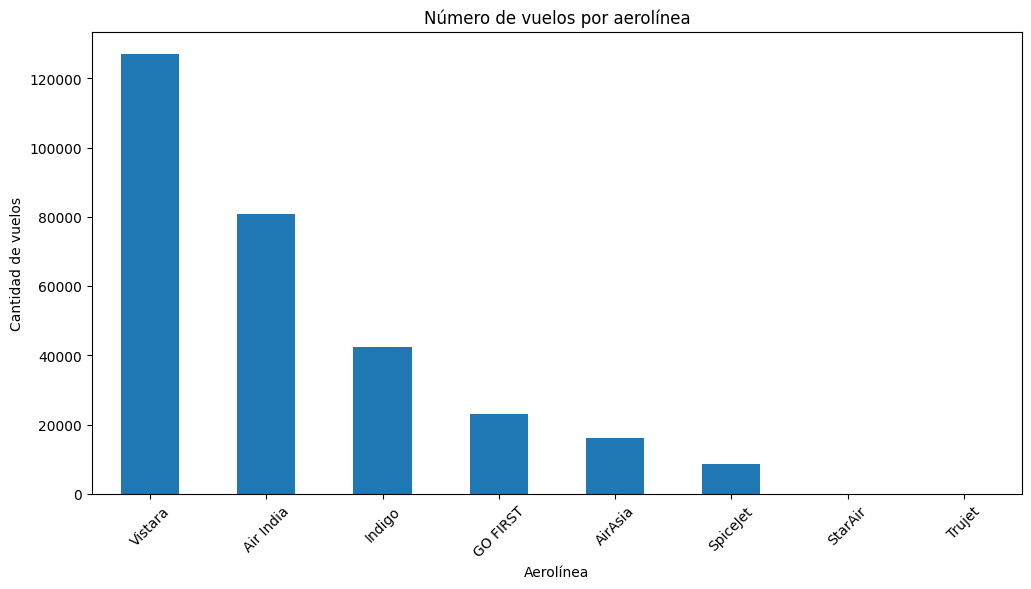

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
df_final['airline'].value_counts().plot(kind='bar')
plt.title("Número de vuelos por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Cantidad de vuelos")
plt.xticks(rotation=45)
plt.show()


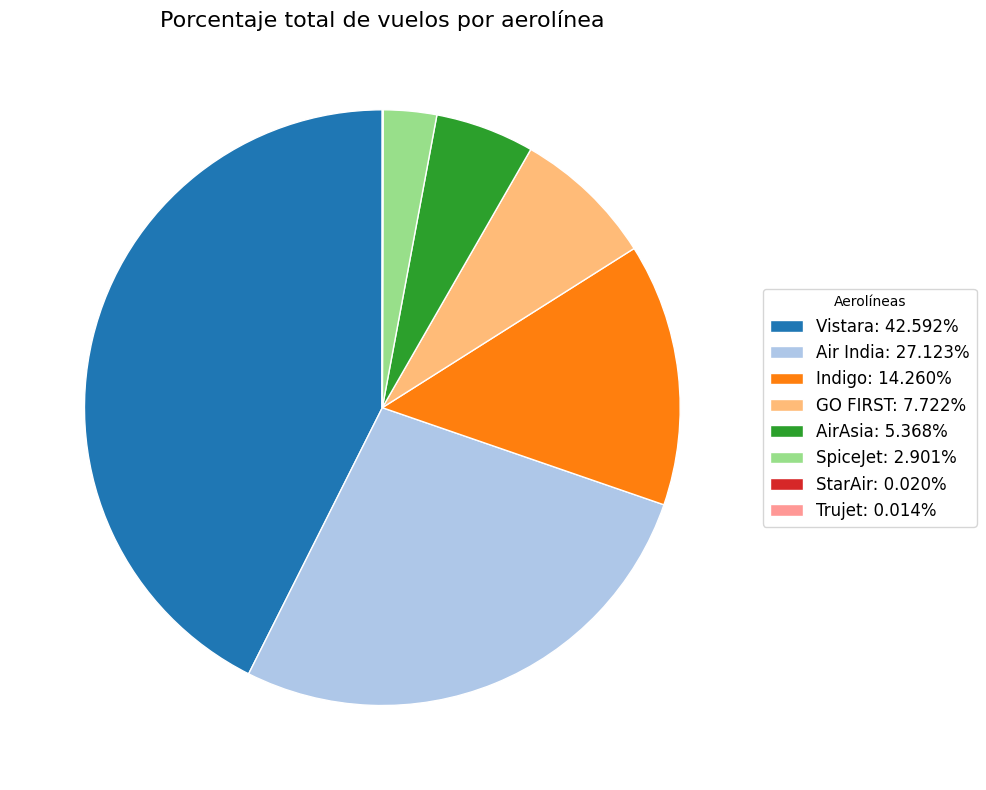

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conteo y porcentaje
counts = df_final["airline"].value_counts()
percent = counts / counts.sum() * 100

plt.figure(figsize=(10, 8))

# Pie chart
plt.pie(
    counts,
    startangle=90,
    colors=sns.color_palette("tab20"),
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)

# Leyenda con porcentajes (3 decimales)
labels = [f"{airline}: {pct:.3f}%" for airline, pct in zip(counts.index, percent)]
plt.legend(
    labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    title="Aerolíneas"
)

plt.title("Porcentaje total de vuelos por aerolínea", fontsize=16)
plt.tight_layout()
plt.show()


Ingresos aproximados por aerolínea

In [80]:
df_final.groupby('airline')['price'].sum().sort_values(ascending=False)


airline
Vistara      3.872755e+09
Air India    1.901366e+09
Indigo       2.272777e+08
GO FIRST     1.304352e+08
AirAsia      6.562651e+07
SpiceJet     5.371012e+07
StarAir      3.008920e+05
Trujet       1.330300e+05
Name: price, dtype: float64

El dinero esta en rupias 

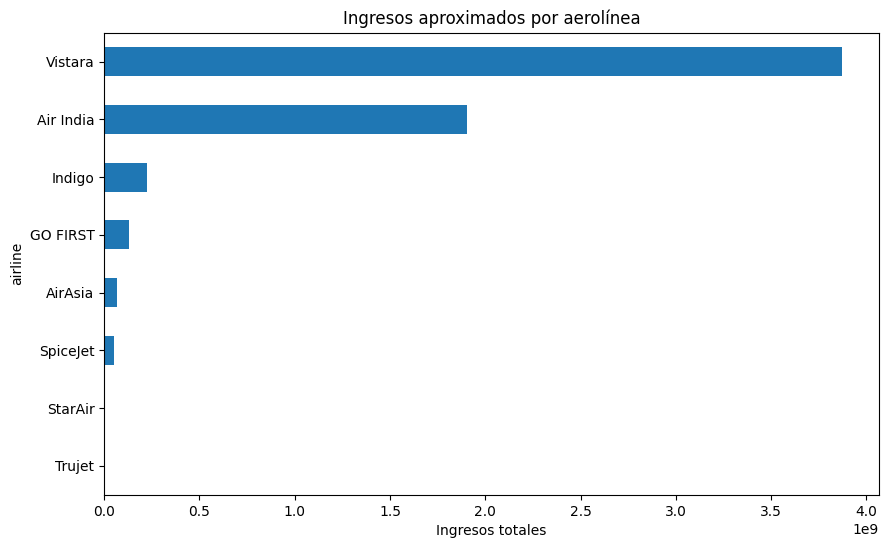

In [81]:
df_final.groupby('airline')['price'].sum().sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Ingresos aproximados por aerolínea")
plt.xlabel("Ingresos totales")
plt.show()


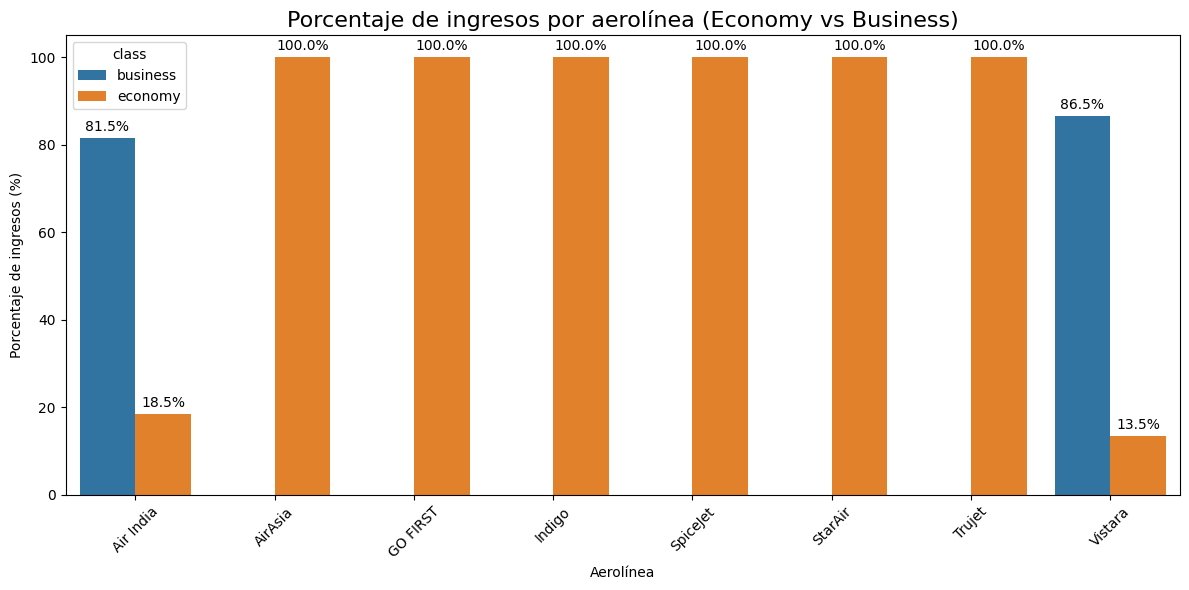

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar ingresos por aerolínea y clase
income_class = df_final.groupby(['airline', 'class'])['price'].sum().reset_index()

# Calcular porcentaje dentro de cada aerolínea
income_class['percent'] = income_class.groupby('airline')['price'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(12,6))

ax = sns.barplot(
    data=income_class,
    x='airline',
    y='percent',
    hue='class',
    palette='tab10'
)

# Añadir etiquetas de porcentaje encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.title("Porcentaje de ingresos por aerolínea (Economy vs Business)", fontsize=16)
plt.xlabel("Aerolínea")
plt.ylabel("Porcentaje de ingresos (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Porcentaje por aerolinea de vuelos business

C:\Users\César\AppData\Local\Temp\ipykernel_24684\1839612190.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


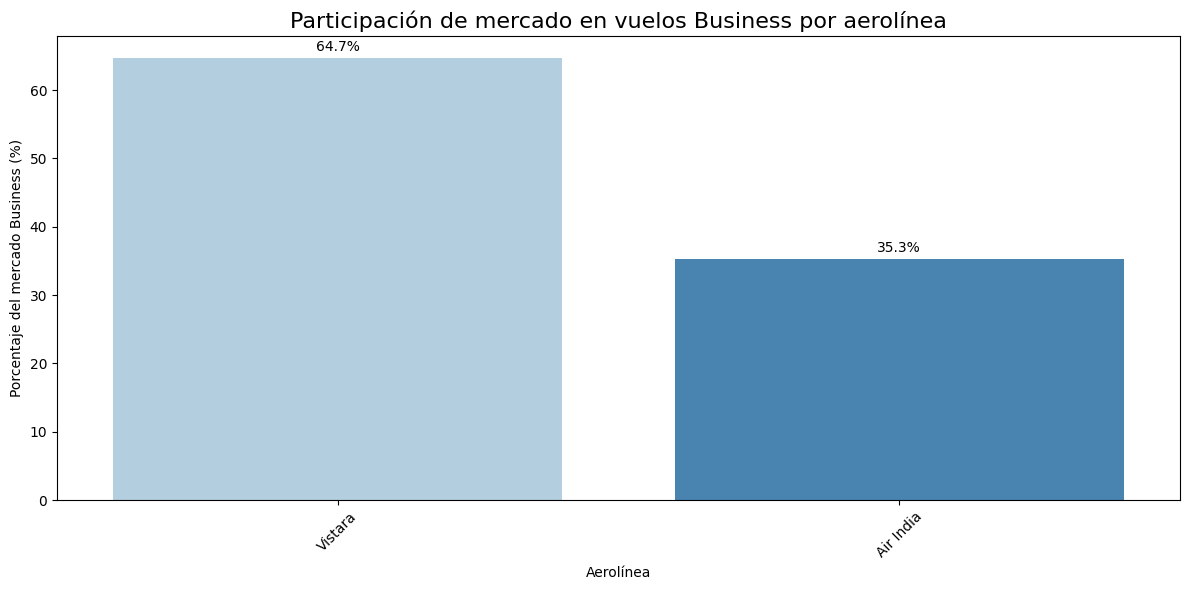

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo vuelos Business
business_df = df_final[df_final['class'] == 'business']

# Contar vuelos business por aerolínea
business_counts = business_df['airline'].value_counts()

# Calcular porcentaje sobre el total del mercado business
business_percent = business_counts / business_counts.sum() * 100

plt.figure(figsize=(12,6))
ax = sns.barplot(
    x=business_percent.index,
    y=business_percent.values,
    palette="Blues"
)

# Etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.title("Participación de mercado en vuelos Business por aerolínea", fontsize=16)
plt.xlabel("Aerolínea")
plt.ylabel("Porcentaje del mercado Business (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Porcentaje por aerolinea de Economy

C:\Users\César\AppData\Local\Temp\ipykernel_24684\3202894572.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


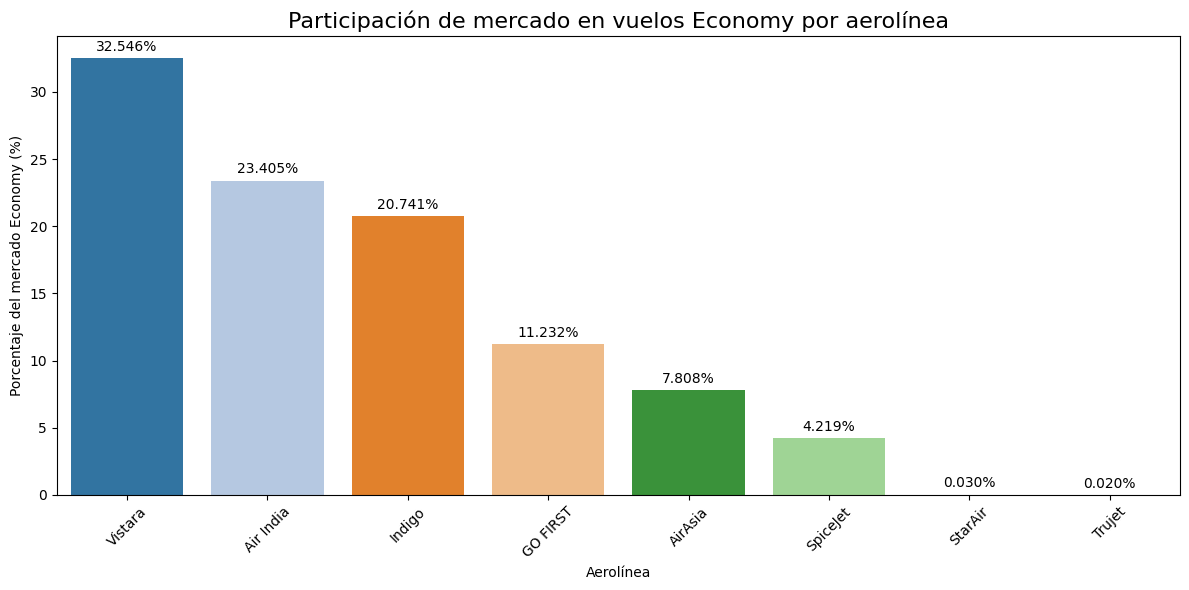

In [84]:
# Paleta igual que el pie chart
colors = sns.color_palette("tab20")

# Orden de aerolíneas según el pie chart
counts = df_final["airline"].value_counts()
airline_order = counts.index.tolist()

# Filtrar solo vuelos Economy
economy_df = df_final[df_final['class'] == 'economy']

# Contar vuelos economy por aerolínea
economy_counts = economy_df['airline'].value_counts()

# Calcular porcentaje sobre el total del mercado economy
economy_percent = economy_counts / economy_counts.sum() * 100

# Alinear colores con el orden del pie chart
economy_colors = [colors[airline_order.index(a)] for a in economy_percent.index]

plt.figure(figsize=(12,6))
ax = sns.barplot(
    x=economy_percent.index,
    y=economy_percent.values,
    palette=economy_colors
)

# Etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%', padding=3)

plt.title("Participación de mercado en vuelos Economy por aerolínea", fontsize=16)
plt.xlabel("Aerolínea")
plt.ylabel("Porcentaje del mercado Economy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Analizando todo esto 

Air India debe ser tu aerolínea
Y te explico por qué es la opción más sólida:

1. Tiene un tamaño grande pero no dominante
- No es tan gigante como Vistara
- No es tan pequeña como Indigo
- Está justo en el medio

2. Tiene mezcla de clases
- 35% del mercado Business
- 23% del mercado Economy
- Ingresos altos pero no extremos
- Esto es perfecto para un modelo de ML porque hay variabilidad real.

3. Tiene rivales claros
- Premium: Vistara
- Low‑cost: Indigo, GO FIRST, AirAsia, SpiceJet
- Tu modelo podrá aprender patrones de ambos mundos.

4. Es la aerolínea más equilibrada del dataset
- Ni demasiado premium
- Ni demasiado low‑cost
- Ni demasiado pequeña
- Ni demasiado dominante

Es la aerolínea “intermedia” ideal para un proyecto académico.

¿Por qué NO incluir StarAir y TruJet?
Tus gráficos muestran:

StarAir:
- 0.02% de los vuelos
- ingresos insignificantes
- casi sin datos
- comportamiento no representativo
- demasiado ruido para un modelo de ML

TruJet:
- 0.014% de los vuelos
- aún menos datos
- no aporta señal
- puede distorsionar el modelo

Son outliers del mercado, no competidores reales de Air India

Qué aerolíneas SÍ incluir?

Estas son las que realmente compiten en el mercado:

Vistara: 
- Rival premium
- Mucho volumen
- Precios altos
- Perfecta para estudiar

GO FIRST:
- Low‑cost
- Competidor directo en rutas económicas

AirAsia
- Low‑cost
- Patrón de precios interesante

SpiceJet
- Low‑cost
- Competidor real en rutas domésticas

In [85]:
# Aerolíneas que queremos eliminar del dataset
a_remove = ["Air India", "StarAir", "Trujet"]

# Crear el nuevo dataframe filtrado
df_ml = df_final[~df_final["airline"].isin(a_remove)].copy()

df_ml.head()


,airline,source_city,destination_city,price,duration,dep_time_cat,arr_time_cat,days_left,class,stop_num
0,SpiceJet,Delhi,Mumbai,5953.0,2.166667,Evening,Night,0,economy,0
1,SpiceJet,Delhi,Mumbai,5953.0,2.333333,Early Morning,Morning,0,economy,0
2,AirAsia,Delhi,Mumbai,5956.0,2.166667,Early Morning,Early Morning,0,economy,0
3,Vistara,Delhi,Mumbai,5955.0,2.250000,Morning,Afternoon,0,economy,0
4,Vistara,Delhi,Mumbai,5955.0,2.333333,Morning,Morning,0,economy,0


In [86]:
df_ml.info()

<class 'pandas.DataFrame'>
Index: 217225 entries, 0 to 298208
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           217225 non-null  str    
 1   source_city       217225 non-null  str    
 2   destination_city  217225 non-null  str    
 3   price             217225 non-null  float64
 4   duration          217225 non-null  float64
 5   dep_time_cat      217225 non-null  str    
 6   arr_time_cat      217225 non-null  str    
 7   days_left         217225 non-null  int64  
 8   class             217225 non-null  str    
 9   stop_num          217225 non-null  int64  
dtypes: float64(2), int64(2), str(6)
memory usage: 18.2 MB


In [87]:
df_ml.describe()

,price,duration,days_left,stop_num
count,217225.000000,217225.000000,217225.000000,217225.000000
mean,20024.419883,11.077931,25.193546,0.916115
std,23304.681420,6.617793,13.488459,0.408854
min,1105.000000,0.833333,0.000000,0.000000
25%,4502.000000,6.333333,14.000000,1.000000
50%,6728.000000,10.083333,25.000000,1.000000
75%,38099.000000,14.500000,37.000000,1.000000
max,123071.000000,47.083333,48.000000,2.000000


Matriz de correlacion 

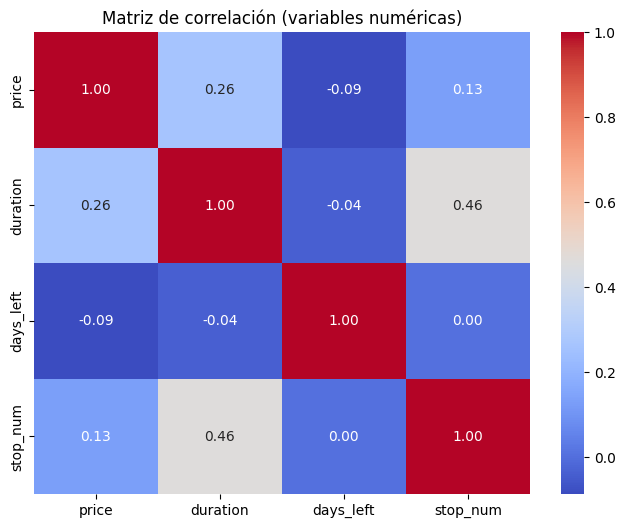

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas
num_cols = ['price', 'duration', 'days_left', 'stop_num']

corr_matrix = df_ml[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación (variables numéricas)")
plt.show()


Histograma de la variable target 

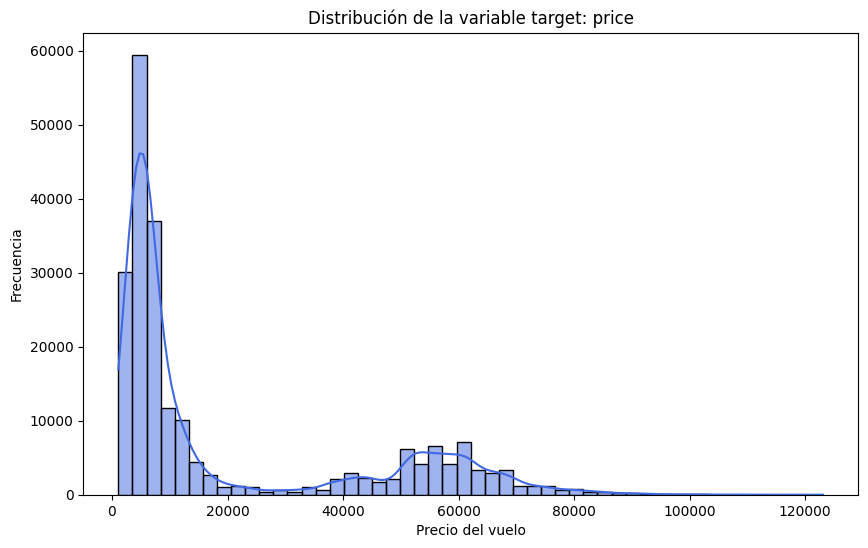

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_ml['price'], bins=50, kde=True, color='royalblue')
plt.title("Distribución de la variable target: price")
plt.xlabel("Precio del vuelo")
plt.ylabel("Frecuencia")
plt.show()


**Machine_Learning**

In [90]:
features_num = ['duration', 'days_left', 'stop_num']

features_cat = [
    'airline',
    'source_city',
    'destination_city',
    'dep_time_cat',
    'arr_time_cat',
    'class'
]



In [91]:
from sklearn.model_selection import train_test_split

X = df_ml[features_num + features_cat]
y = df_ml['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [ ]:
'''from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat),
        ('num', StandardScaler(), features_num)
    ]
)'''


PIPELINE 1 — Modelos lineales (OneHot + StandardScaler)

In [92]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat),
        ('num', StandardScaler(), features_num)
    ]
)


PIPELINE 2 — Modelos de árboles (OneHot + numéricas sin tocar)

In [ ]:
'''preprocessor_trees = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat),
        ('num', 'passthrough', features_num)
    ]
)'''


In [93]:
from sklearn.preprocessing import OrdinalEncoder

preprocessor_trees = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), features_cat),
        ('num', 'passthrough', features_num)
    ]
)


PIPELINE 3 — CatBoost (sin preprocesamiento)

In [94]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=600,
    loss_function="RMSE",
    verbose=0,
    random_state=42
)


In [95]:
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)


BLOQUE 1 — Modelos lineales

In [96]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

models_linear = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

results_linear = {}

for name, reg in models_linear.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', reg)
    ])
    
    rmse = -cross_val_score(pipe, X_train, y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    
    mae  = -cross_val_score(pipe, X_train, y_train,
                            scoring=mae_scorer,
                            cv=5, n_jobs=-1).mean()
    
    r2   =  cross_val_score(pipe, X_train, y_train,
                            scoring=r2_scorer,
                            cv=5, n_jobs=-1).mean()

    results_linear[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"\n📌 {name}")
    print(f"   RMSE CV: {rmse:.2f}")
    print(f"   MAE  CV: {mae:.2f}")
    print(f"   R²   CV: {r2:.4f}")



📌 LinearRegression
   RMSE CV: 6704.70
   MAE  CV: 4256.78
   R²   CV: 0.9171

📌 Ridge
   RMSE CV: 6704.70
   MAE  CV: 4256.65
   R²   CV: 0.9171

📌 Lasso
   RMSE CV: 6704.72
   MAE  CV: 4254.87
   R²   CV: 0.9171


BLOQUE 2 — Modelos de árboles

In [97]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models_trees = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=400, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
}

results_trees = {}

for name, reg in models_trees.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor_trees),
        ('regressor', reg)
    ])
    
    rmse = -cross_val_score(pipe, X_train, y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    
    mae  = -cross_val_score(pipe, X_train, y_train,
                            scoring=mae_scorer,
                            cv=5, n_jobs=-1).mean()
    
    r2   =  cross_val_score(pipe, X_train, y_train,
                            scoring=r2_scorer,
                            cv=5, n_jobs=-1).mean()

    results_trees[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"\n📌 {name}")
    print(f"   RMSE CV: {rmse:.2f}")
    print(f"   MAE  CV: {mae:.2f}")
    print(f"   R²   CV: {r2:.4f}")



📌 RandomForest
   RMSE CV: 3028.55
   MAE  CV: 1247.54
   R²   CV: 0.9831

📌 XGBoost
   RMSE CV: 3737.24
   MAE  CV: 2118.54
   R²   CV: 0.9742

📌 LightGBM
   RMSE CV: 3633.81
   MAE  CV: 2112.41
   R²   CV: 0.9756


BLOQUE 3 — CatBoost (sin preprocesador)

In [98]:
results_cat = {}

rmse = -cross_val_score(model_cat, X_train, y_train,
                        scoring='neg_root_mean_squared_error',
                        cv=5, n_jobs=-1).mean()

mae  = -cross_val_score(model_cat, X_train, y_train,
                        scoring=mae_scorer,
                        cv=5, n_jobs=-1).mean()

r2   =  cross_val_score(model_cat, X_train, y_train,
                        scoring=r2_scorer,
                        cv=5, n_jobs=-1).mean()

results_cat["CatBoost"] = {"RMSE": rmse, "MAE": mae, "R2": r2}

print(f"\n📌 CatBoost")
print(f"   RMSE CV: {rmse:.2f}")
print(f"   MAE  CV: {mae:.2f}")
print(f"   R²   CV: {r2:.4f}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2606, in _catboost.get_float_feature
  File "_catboost.pyx", line 1290, in _catboost._FloatOrNan
  File "_catboost.pyx", line 1039, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'Vistara' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\catboost\core.py", line 6178, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\catboost\core.py", line 2701, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\catboost\core.py", line 2581, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\catboost\core.py", line 1540, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\catboost\core.py", line 863, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "c:\Users\César\OneDrive\Escritorio\DS\ML_Prediccion_Precios_Vuelos\.venv\Lib\site-packages\catboost\core.py", line 1518, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4695, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4753, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4541, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3189, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2673, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2635, in _catboost._set_features_order_data_frame_generic_num_column
  File "_catboost.pyx", line 2608, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Vistara": Cannot convert 'Vistara' to float


BLOQUE 1 — Modelos lineales

In [91]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import numpy as np

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

models_linear = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

results_linear = {}

for name, reg in models_linear.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', reg)
    ])
    
    rmse = -cross_val_score(pipe, X_train, y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    
    mae  = -cross_val_score(pipe, X_train, y_train,
                            scoring=mae_scorer,
                            cv=5, n_jobs=-1).mean()
    
    r2   =  cross_val_score(pipe, X_train, y_train,
                            scoring=r2_scorer,
                            cv=5, n_jobs=-1).mean()

    results_linear[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"\n📌 {name}")
    print(f"   RMSE CV: {rmse:.2f}")
    print(f"   MAE  CV: {mae:.2f}")
    print(f"   R²   CV: {r2:.4f}")



📌 LinearRegression
   RMSE CV: 6704.70
   MAE  CV: 4256.78
   R²   CV: 0.9171

📌 Ridge
   RMSE CV: 6704.70
   MAE  CV: 4256.65
   R²   CV: 0.9171

📌 Lasso
   RMSE CV: 6704.72
   MAE  CV: 4254.87
   R²   CV: 0.9171


BLOQUE 2 — Modelos de árboles

In [92]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models_trees = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        objective="reg:squarederror", random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=400, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

results_trees = {}

for name, reg in models_trees.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor_trees),
        ('regressor', reg)
    ])
    
    rmse = -cross_val_score(pipe, X_train, y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    
    mae  = -cross_val_score(pipe, X_train, y_train,
                            scoring=mae_scorer,
                            cv=5, n_jobs=-1).mean()
    
    r2   =  cross_val_score(pipe, X_train, y_train,
                            scoring=r2_scorer,
                            cv=5, n_jobs=-1).mean()

    results_trees[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"\n📌 {name}")
    print(f"   RMSE CV: {rmse:.2f}")
    print(f"   MAE  CV: {mae:.2f}")
    print(f"   R²   CV: {r2:.4f}")


KeyboardInterrupt: 

BLOQUE 3 — CatBoost (sin preprocesador)

In [ ]:
results_cat = {}

rmse = -cross_val_score(model_cat, X_train, y_train,
                        scoring='neg_root_mean_squared_error',
                        cv=5, n_jobs=-1).mean()

mae  = -cross_val_score(model_cat, X_train, y_train,
                        scoring=mae_scorer,
                        cv=5, n_jobs=-1).mean()

r2   =  cross_val_score(model_cat, X_train, y_train,
                        scoring=r2_scorer,
                        cv=5, n_jobs=-1).mean()

results_cat["CatBoost"] = {"RMSE": rmse, "MAE": mae, "R2": r2}

print(f"\n📌 CatBoost")
print(f"   RMSE CV: {rmse:.2f}")
print(f"   MAE  CV: {mae:.2f}")
print(f"   R²   CV: {r2:.4f}")


In [189]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),

    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),

    "CatBoost": CatBoostRegressor(
        depth=8,
        learning_rate=0.05,
        iterations=600,
        loss_function="RMSE",
        verbose=0,
        random_state=42
    )
}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import numpy as np

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

results = {}

for name, reg in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    
    # RMSE
    rmse_scores = cross_val_score(
        pipe, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    
    # MAE
    mae_scores = cross_val_score(
        pipe, X_train, y_train,
        scoring=mae_scorer,
        cv=5
    )
    
    # R²
    r2_scores = cross_val_score(
        pipe, X_train, y_train,
        scoring=r2_scorer,
        cv=5
    )
    
    results[name] = {
        "RMSE_CV": -rmse_scores.mean(),
        "MAE_CV": -mae_scores.mean(),
        "R2_CV": r2_scores.mean()
    }
    
    print(f"\n📌 Modelo: {name}")
    print(f"   RMSE CV: {-rmse_scores.mean():.2f}")
    print(f"   MAE  CV: {-mae_scores.mean():.2f}")
    print(f"   R²   CV: {r2_scores.mean():.4f}")



📌 Modelo: LinearRegression
   RMSE CV: 6704.70
   MAE  CV: 4256.78
   R²   CV: 0.9171

📌 Modelo: Ridge
   RMSE CV: 6704.70
   MAE  CV: 4256.65
   R²   CV: 0.9171

📌 Modelo: Lasso
   RMSE CV: 6704.72
   MAE  CV: 4254.87
   R²   CV: 0.9171


In [23]:


dup_economy = df_economy[df_economy.duplicated(subset=cols, keep=False)]
dup_business = df_business[df_business.duplicated(subset=cols, keep=False)]

len(dup_economy), len(dup_business)


(70, 0)

In [24]:
df_concat = pd.concat([df_economy, df_business], ignore_index=True)

df_concat_clean = df_concat.drop_duplicates(subset=cols)

df_concat.shape[0] - df_concat_clean.shape[0]


35